## Exploratory Data Analysis: MIMIC-III v1.4



In [1]:
DATA_DIR = '../data/mimic-iii/final'

### Convenience functions

In [2]:
# dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [3]:
def read_csv(fname, parse_dates=[]):
    df = pd.read_csv(fname)
    for col in parse_dates:
        df[col] = pd.to_datetime(df[col])
    return df

def histogram(df, col, bins=50, label=None, type_col=None, num_cols=2, x_label='Value'):
    # Single measurement type in `df`
    if type_col is None and type(col) == str:
        plt.figure(figsize=(8, 6))
        if label:
            plt.hist(df[col].values, bins=bins, label=label)
            plt.legend()
        else:
            plt.hist(df[col].values, bins=bins)
        plt.show()
        
    # Multiple columns as separate histograms
    elif type(col) == list:
        num_rows = len(df) // num_cols
        
        plt.figure(figsize=(7 * num_cols, 5 * num_rows))
        for i, col_label in enumerate(col):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.hist(df[col_label].values, bins=bins, alpha=0.5)
            plt.title(col_label)
            plt.xlabel(x_label)
            plt.ylabel('Frequency')
        plt.show()
    
    # Multiple measurement types indexed by `type_col`
    else:
        num_rows = len(set(df[type_col].values)) // num_cols
        
        plt.figure(figsize=(7 * num_cols, 5 * num_rows))
        for i, (label, subdf) in enumerate(df.groupby(type_col)):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.hist(subdf[col].values, bins=bins, alpha=0.5)
            plt.title(label)
            plt.xlabel(x_label)
            plt.ylabel('Frequency')
        plt.show()
        
        
def missing_values_in_intervals(df, item_col=None, freq='1H'):
    df['rounded_charttime'] = df['charttime'].dt.round(freq='H')
    df['rounded_window_start'] = df['window_start'].dt.round(freq='H')
    df['rounded_window_end'] = df['window_end'].dt.round(freq='H')
    
    measurements = defaultdict(list)

    # Consider ICU stays separately
    for icustay_id, icustay_data in df.groupby('icustay_id'):
        # Define hourly intervals
        starttime = icustay_data['rounded_window_start'].min()
        endtime = icustay_data['rounded_window_end'].max()
        date_range = set(pd.date_range(start=starttime, end=endtime, freq='1H'))

        # Check recordings of each item (e.g. vital)
        for item_id, item_data in icustay_data.groupby(item_col):
            timestamps = set(item_data['rounded_charttime'])

            # Percentage of `date_range` covered
            perc_measured = len(timestamps.intersection(date_range)) / len(date_range)
            measurements[item_id].append(perc_measured)
        
    return {item:np.mean(measurements[item]) for item in measurements.keys()}
    

---
### General Data Statistics

In [4]:
# Load cohort.csv data
cohort_df = read_csv(DATA_DIR + '/cohort.csv', ['intime', 'outtime', 'window_start', 'window_end', 'suspected_infection_time_poe'])
cohort_df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,10006,142345,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 15:30:00,2164-10-22 15:30:00,2164-10-25 15:30:00,0
1,10013,165520,264446,2125-10-04 23:38:00,2125-10-07 15:13:52,2125-10-05 02:00:00,2125-10-04 02:00:00,2125-10-07 02:00:00,1
2,10017,199207,204881,2149-05-29 18:52:29,2149-05-31 22:19:17,2149-05-27 05:15:00,2149-05-26 05:15:00,2149-05-29 05:15:00,0
3,10019,177759,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,2163-05-14 21:52:00,2163-05-13 21:52:00,2163-05-16 21:52:00,1
4,10026,103770,277021,2195-05-17 07:40:18,2195-05-19 17:24:25,2195-05-17 09:12:00,2195-05-16 09:12:00,2195-05-19 09:12:00,0


In [5]:
subject_ids = set(cohort_df['subject_id'])
hadm_ids = set(cohort_df['hadm_id'])
icustay_ids = set(cohort_df['icustay_id'])

avg_duration = round((cohort_df['outtime'] - cohort_df['intime']).mean().total_seconds() / (3600 * 24), 1)
std_duration = round((cohort_df['outtime'] - cohort_df['intime']).std().total_seconds() / (3600 * 24), 1)

avg_time_to_infect = round((cohort_df['suspected_infection_time_poe'] - cohort_df['intime']).mean().total_seconds() / (3600 * 24), 1)
std_time_to_infect = round((cohort_df['suspected_infection_time_poe'] - cohort_df['intime']).std().total_seconds() / (3600 * 24), 1)

day30_mortality = cohort_df['hospital_expire_flag'].mean()

pd.DataFrame({'Total patients': [len(subject_ids)],
              'Total hospital admissions': len(hadm_ids),
              'Total ICU admissions': len(icustay_ids),
              'Avg. ICU admissions per patient': len(icustay_ids) / len(subject_ids),
              'Avg. time spent at ICU': '%s (±%s days)' % (avg_duration, std_duration),
              'Avg. time to infection': '%s (±%s days)' % (avg_time_to_infect, std_time_to_infect),
              '30-day mortality': day30_mortality}).T.rename({0: 'Value'}, axis=1)

,Value
Total patients,60
Total hospital admissions,60
Total ICU admissions,60
Avg. ICU admissions per patient,1.0
Avg. time spent at ICU,5.6 (±7.9 days)
Avg. time to infection,-0.2 (±2.5 days)
30-day mortality,0.316667


*Remarks:*
1. The negative `Avg. time to infection` indicates that patients often develop an infection prior to ICU admission (e.g. at a general ward).
2. Estimated mortality within 30 days is approx. 30\% (expected from literature).

--- 
## Patient Cohort

In [6]:
demographics_df = read_csv(DATA_DIR + '/demographics_cohort.csv')
demographics_df.head()

,subject_id,hadm_id,icustay_id,age,is_male,race_white,race_black,race_hispanic,race_other,height,...,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive
0,10076,198503,201006,68.8612,1,0,0,0,1,NaN,...,1,8,7,4,2,1,0,1,15,1
1,42321,114648,201204,80.5603,0,0,0,0,1,163.00,...,0,5,7,2,3,1,1,1,9,0
2,10045,126949,203766,68.6668,0,1,0,0,0,165.10,...,1,12,12,3,2,1,0,1,12,0
3,10104,177678,204201,70.5176,0,0,0,0,1,157.48,...,0,5,7,1,2,1,1,0,13,1
4,10017,199207,204881,73.6772,0,1,0,0,0,NaN,...,0,2,0,4,2,1,0,1,-1,0


#### Demographics

In [7]:
pd.DataFrame({'Male': [demographics_df['is_male'].mean()],
              'White (Ethnicity)': demographics_df['race_white'].mean(),
              'Black (Ethnicity)': demographics_df['race_black'].mean(),
              'Hispanic (Ethnicity)': demographics_df['race_hispanic'].mean(),
              'Other (Ethnicity)': demographics_df['race_other'].mean(),
              'On ventilator': demographics_df['vent'].mean(),
              'Blood culture': demographics_df['blood_culture_positive'].mean()}).T.rename({0: 'Value (%)'}, axis=1)

,Value (%)
Male,0.466667
White (Ethnicity),0.766667
Black (Ethnicity),0.066667
Hispanic (Ethnicity),0.033333
Other (Ethnicity),0.133333
On ventilator,0.450000
Blood culture,0.483333


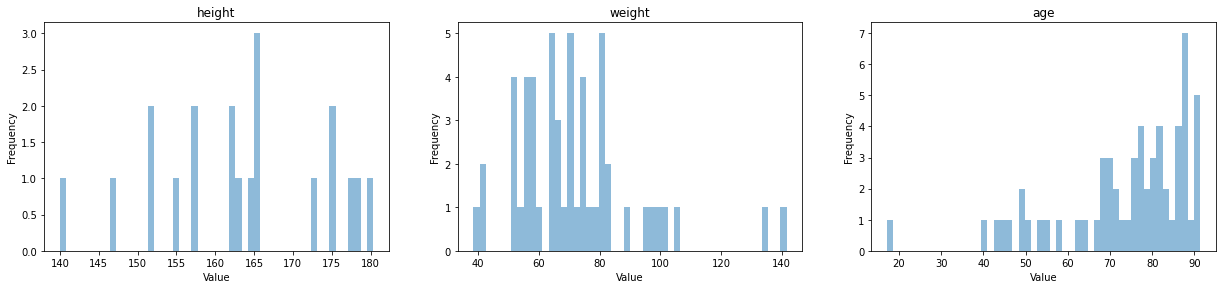

In [8]:
histogram(demographics_df, col=['height', 'weight', 'age'], num_cols=3)

#### Disease Severity Scores

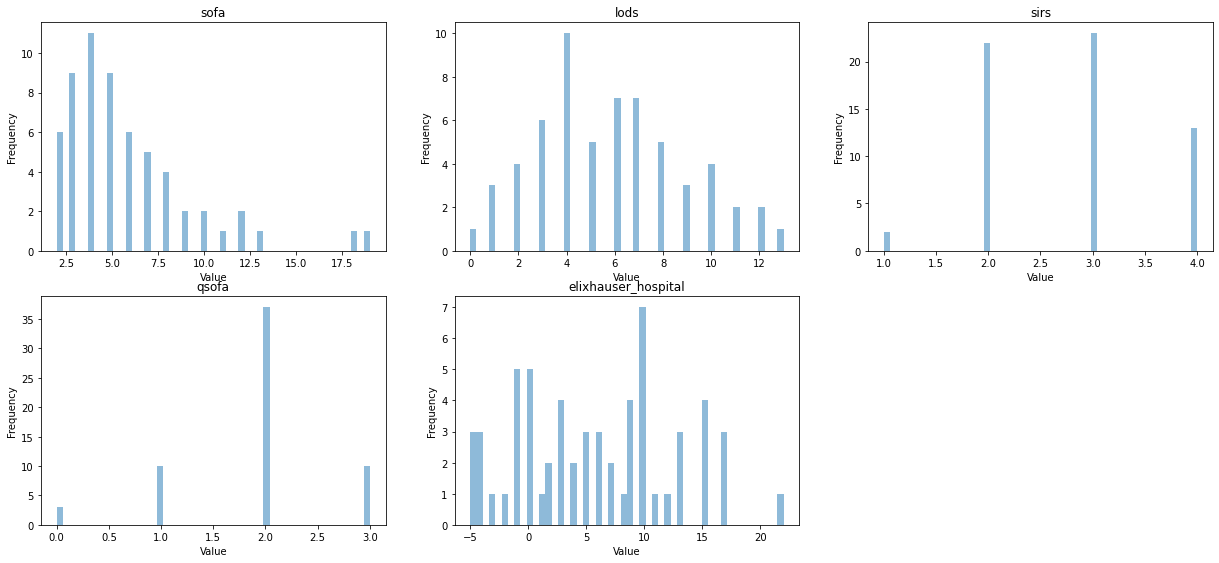

In [9]:
histogram(demographics_df, col=['sofa', 'lods', 'sirs', 'qsofa', 'elixhauser_hospital'], num_cols=3)

*Remarks:*

1. Clear overrepresentation of `race_white` (76.6\%); a near 50-50 balance between men and women.
2. For a mere 48.3% of patients a blood culture is found (or grown?) which contradicts the idea that a culture must be found before sepsis can be verified. 
3. Overrepresentation of the elderly (expected as the elderly are more likely to develop sepsis).

---
## Vitals

In [10]:
# Load vitals.csv data
vitals_df = read_csv(DATA_DIR + '/vitals_cohort.csv', ['intime', 'outtime', 'window_start', 'window_end', 'charttime'])
vitals_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,DiasBP,50.000000
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,HeartRate,104.000000
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,MeanBP,63.666698
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,RespRate,25.000000
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,SpO2,98.000000


#### General Data Statistics

In [11]:
# Which vitals exist?
vitals_df.groupby('vital_id')['icustay_id'].count()

vital_id
DiasBP       2603
Glucose       477
HeartRate    2546
MeanBP       2632
RespRate     2541
SpO2         2494
SysBP        2611
TempC         747
Name: icustay_id, dtype: int64

#### Spread of measurements (by type):

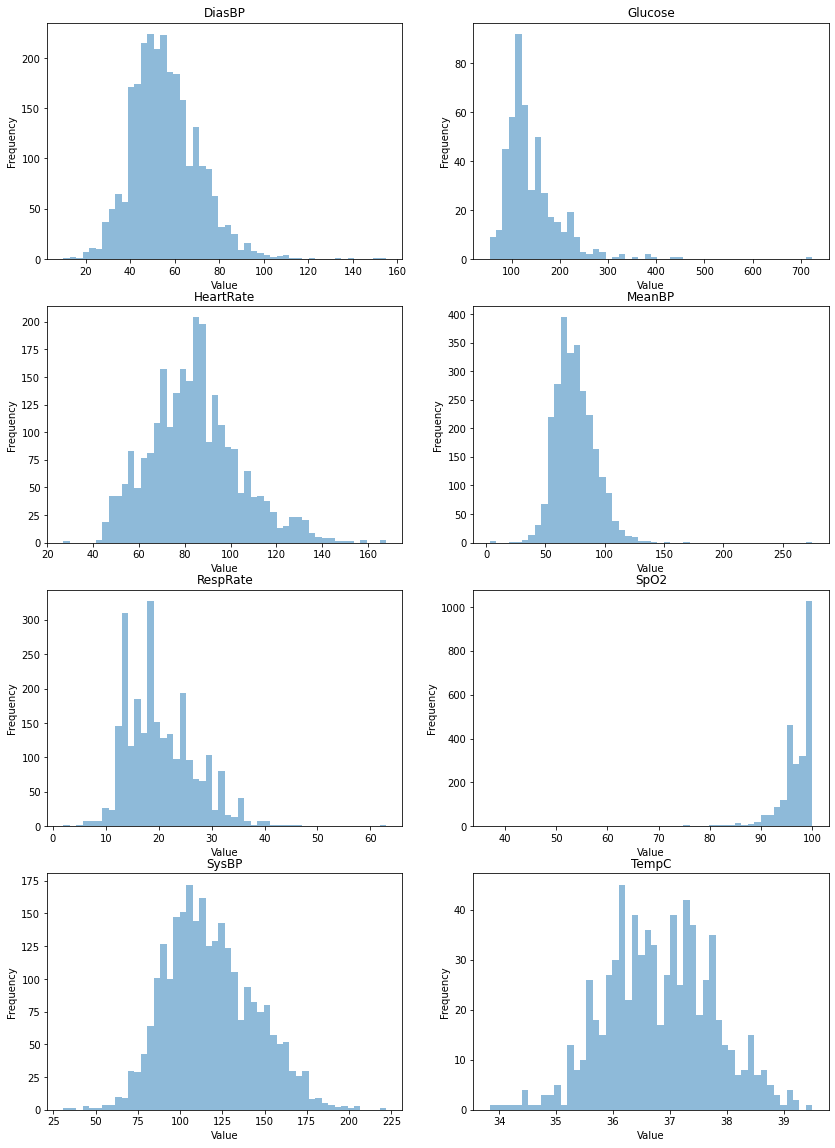

In [12]:
histogram(vitals_df, col='valuenum', type_col='vital_id')

#### Spread of differences of measurment acquisition times (by type):

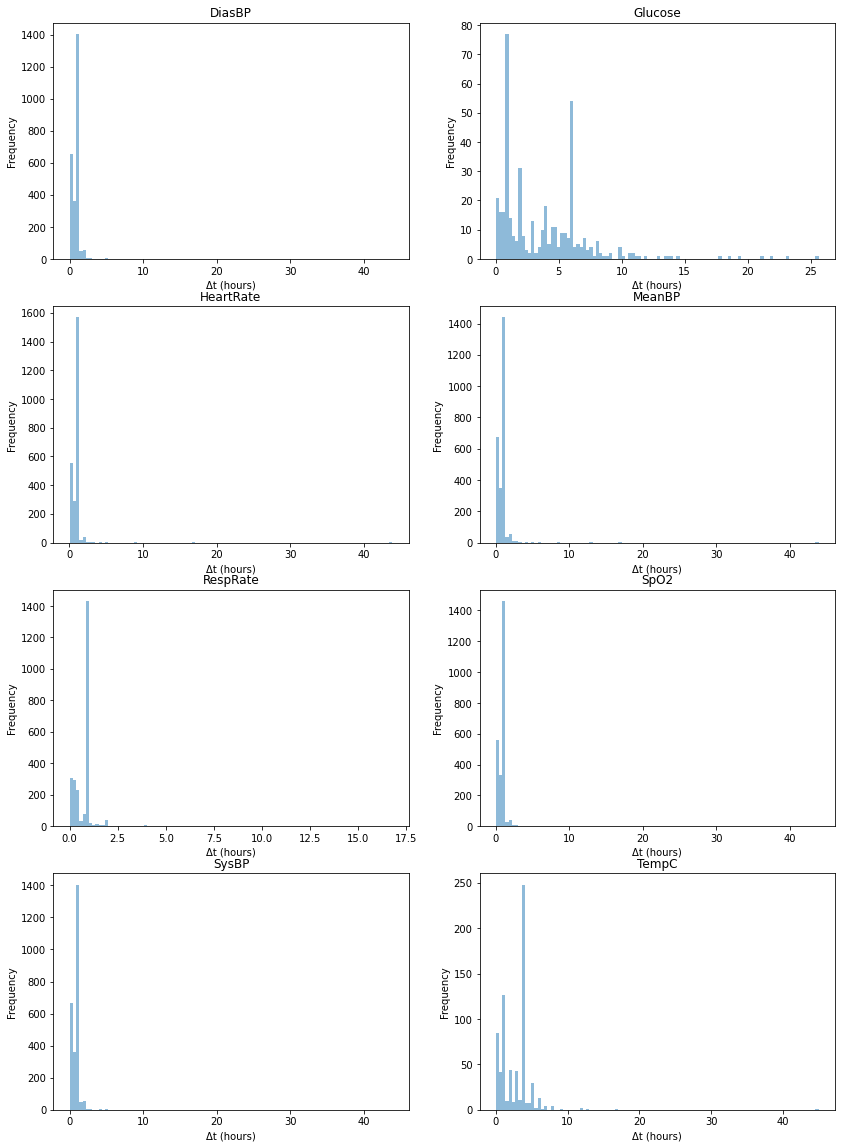

In [13]:
# Compute difference in measurement times for eaach measurement type in hours
vitals_df = vitals_df.sort_values(['icustay_id', 'charttime'])
vitals_df['time_diff'] = vitals_df.groupby(['icustay_id', 'vital_id'])['charttime'].diff().dt.total_seconds() / 3600

histogram(vitals_df, col='time_diff', type_col='vital_id', x_label='Δt (hours)', bins=100)

#### Missing values (in hourly windows)

In [14]:
print('Percentage of recorded vital measurements (per hour):')
missing_values_in_intervals(vitals_df, item_col='vital_id')

Percentage of recorded vital measurements (per hour):


{'DiasBP': 0.4729763387297633,
 'Glucose': 0.11187214611872143,
 'HeartRate': 0.48991282689912824,
 'MeanBP': 0.47621419676214194,
 'RespRate': 0.4704856787048568,
 'SpO2': 0.4752179327521793,
 'SysBP': 0.4729763387297633,
 'TempC': 0.16768138001014712}

*Remarks:*

1. Different distributions for different vital functions.
2. Most vitals ignals have a $\Delta t$ within 1~2 hours, with the exception of `Glucose` and `TempC`, which are being measured highly infrequently (increasing $\Delta t$).

1. Missing value percentage is very high (>50\% for all vital signals).
2. Temperature (`TempC`) and `Glucose` measurements are the most rare, only being recorded in 16.7\% and 11.1\% of hours in the 72h of interest (as was found previously).

---
## FiO2 (Fraction of Inspired Oxygen)

In [15]:
fio2_df = read_csv(DATA_DIR + '/fio2_cohort.csv', parse_dates=['charttime'])
fio2_df.head()

,subject_id,hadm_id,icustay_id,charttime,fio2
0,10013,165520,264446,2125-10-05 00:00:00,60.000002
1,10013,165520,264446,2125-10-05 01:00:00,40.000001
2,10013,165520,264446,2125-10-05 03:00:00,40.000001
3,10013,165520,264446,2125-10-05 07:00:00,69.999999
4,10013,165520,264446,2125-10-05 10:00:00,69.999999


#### Distribution of values:

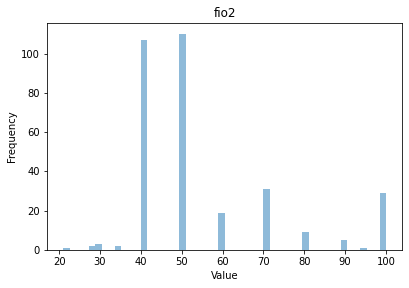

In [16]:
histogram(fio2_df, col=['fio2'], num_cols=2)

#### Distribution of time deltas:

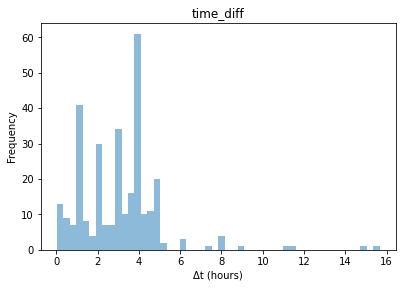

In [17]:
# Compute difference in measurement times for eaach measurement type in hours
fio2_df = fio2_df.sort_values(['icustay_id', 'charttime'])
fio2_df['time_diff'] = fio2_df.groupby(['icustay_id'])['charttime'].diff().dt.total_seconds() / 3600

histogram(fio2_df, col=['time_diff'], x_label='Δt (hours)', bins=50)